# Diffusion lab notebook

A step-by-step notebook derived from `diffusion_lab.py` covering:
- Closed-form DDIM sampling for a Gaussian mixture with detailed score/denoiser derivations.
- Learning a denoiser on a Swiss roll (embedded in high dimension) and sampling with the same DDIM routine.
- A CelebA example using the Hugging Face DDPM via the same DDIM sampler.


In [1]:
import torch
import matplotlib.pyplot as plt
import torch.distributions as D
from tqdm import tqdm
from functools import partial
import numpy as np

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(torch.backends.mps.is_available())
torch.set_default_device(device)
SEED = 42
torch.manual_seed(SEED)

True


## Gaussian mixtures 

# Sampling from a 25-Component Gaussian Mixture Model

In this notebook, we work with a Gaussian Mixture Model (GMM) composed of **25 Gaussian components** arranged on a $5 \times 5$ grid. Each component is an isotropic Gaussian with identity covariance, and the mixture weights are sampled randomly and normalized.

## Definition of the Mixture

The function `gmm_25(dim)` constructs a mixture in an ambient space of dimension `dim`.

- For each pair of coordinates, the means are placed on a grid with spacing $8$.  
- In the simplest case `dim = 2`, the component means are  
  $$\mu_{i,j} = (8i,\; 8j), \qquad i,j \in \{-2,-1,0,1,2\}.$$
- In higher dimensions, these grid coordinates are tiled across coordinate pairs.

All components share the same covariance matrix
$$\Sigma = I_{\text{dim}},$$
and the mixture weights $\{w_k\}$ satisfy  
$$w_k \ge 0, \qquad \sum_{k=1}^{25} w_k = 1.$$

Formally, the distribution is
$$
p(x) = \sum_{k=1}^{25} w_k \, \mathcal{N}(x \mid \mu_k, \Sigma).
$$

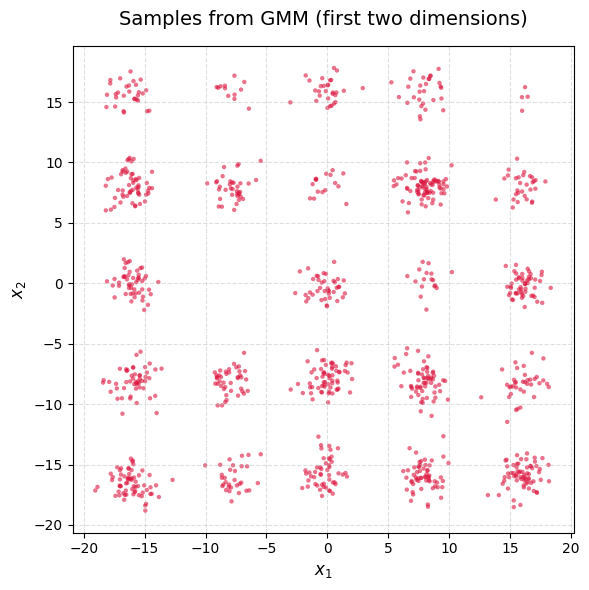

In [2]:
def gmm_25(dim: int = 2):
    """
    Create a 25-component Gaussian mixture arranged on a grid.
    Args:
        dim: Ambient dimensionality; grid coordinates tile across paired dimensions.
    Returns:
        `MixtureSameFamily` distribution with random weights and identity covariances.
    """
    means = torch.tensor(
        [[8 * i, 8 * j] * (dim // 2) for i in range(-2, 3) for j in range(-2, 3)],
        dtype=torch.float32,
    )
    n_mix = means.shape[0]
    covs = torch.eye(dim).unsqueeze(0).repeat(n_mix, 1, 1)
    weights = torch.rand(n_mix)
    weights = weights / weights.sum()
    return D.MixtureSameFamily(
        mixture_distribution=D.Categorical(weights),
        component_distribution=D.MultivariateNormal(means, covs),
    )

torch.manual_seed(SEED)

mixture = gmm_25(dim=2)

samples = mixture.sample((1000,)).cpu()

plt.figure(figsize=(6, 6))
plt.scatter(
    samples[:, 0], samples[:, 1], s=10, alpha=0.6, c="crimson", edgecolors="none"
)
plt.title("Samples from GMM (first two dimensions)", fontsize=14, pad=15)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

## Convolved Gaussian Mixture at Timestep $t$

We start from a Gaussian mixture at $t=0$ of the form

$$
p_0(x) = \sum_{k=1}^K w_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k),
$$

where each component has mean $\mu_k$, covariance $\Sigma_k$, and mixture weight $w_k$.

During forward diffusion, a clean sample $x_0$ is mapped to

$$
X_t = \alpha_t X_0 + \sigma_t X_1,
\qquad X_1 \sim \mathcal{N}(0, I).
$$

Because the forward process is linear and Gaussian, each mixture component remains Gaussian after diffusion.  
Thus, the mixture at timestep $t$ is

$$
p_t(x) = \sum_{k=1}^K w_k \, 
\mathcal{N}\!\left(x \,\middle|\, \alpha_t \mu_k,\; 
\alpha_t^2 \Sigma_k + \sigma_t^2 I \right).
$$

In other words:

- The means are scaled:
  $$
  \mu_k^{(t)} = \alpha_t \mu_k,
  $$

- The covariances inflate according to
  $$
  \Sigma_k^{(t)} = \alpha_t^2 \Sigma_k + \sigma_t^2 I.
  $$

This matches exactly what the function `mixture_t` computes.

---

## Tweedie Formula and the Closed-Form Denoiser

For the variance–preserving forward process  
$$x_t = \alpha_t x_0 + \sigma_t \varepsilon,$$
there is a fundamental identity, **Tweedie’s formula**, relating the posterior mean to the score of the noisy distribution:

$$
\mathbb{E}[x_0 \mid x_t] 
= \frac{x_t + \sigma_t^2 \, \nabla_x \log p_t(x_t)}{\alpha_t}.
$$

Here $\nabla_x \log p_t(x)$ is the **score function** at timestep $t$.

Thus, the denoiser that predicts $x_0$ from a noisy input $x_t$ is:

$$
\hat{x}_0(x_t) 
= \frac{x_t + \sigma_t^2 \, \nabla_x \log p_t(x_t)}{\alpha_t}.
$$

In the notebook:

- The mixture distribution $p_t$ is known in closed form.  
- We can compute its score $\nabla_x \log p_t(x)$ via autograd.  
- Plugging this into Tweedie’s identity yields the exact denoiser.

Implement the ```denoiser_t``` function using ```mixture_t``` below.

In [3]:
def mixture_t(mixture, alpha, sigma):
    """
    Push the base mixture through the forward diffusion at timestep t.
    Args:
        mixture: Base Gaussian mixture at t=0.
        alpha: Alpha coefficient for the target timestep.
        sigma: Sigma coefficient for the target timestep.
    Returns:
        Mixture with scaled means and inflated covariances matching time t.
    """
    means, covs, weights = (
        mixture.component_distribution.mean,
        mixture.component_distribution.covariance_matrix,
        mixture.mixture_distribution.probs,
    )
    means_t = alpha * means
    eye = torch.eye(means.shape[-1], device=means.device)[None, ...].repeat(
        len(weights), 1, 1
    )
    covs_t = alpha.square() * covs + sigma.square() * eye
    mvn = D.MultivariateNormal(means_t, covs_t)
    return D.MixtureSameFamily(D.Categorical(weights), mvn)


def denoiser_t(x, t, mixture, alphas, sigmas):
    """
    Closed-form denoiser for the Gaussian mixture using its score function.
    Args:
        x: Noised sample(s) at timestep t.
        t: Integer timestep index.
        mixture: Base Gaussian mixture distribution.
        alphas: Full alpha schedule.
        sigmas: Full sigma schedule.
    Returns:
        Prediction of the clean sample x0 via the score-based identity.
    """
    
    """
    Implement the denoiser by computing the score first. 
    """
    alpha = alphas[t]
    sigma = sigmas[t]

    x = x.detach().requires_grad_(True)
    log_p = mixture_t(mixture, alpha, sigma).log_prob(x)
    score = torch.autograd.grad(log_p.sum(), x)[0]
    # alors le .sum() qui est là wtf ? 
    # je l'ai ajouté car 
    # il est nécessaire pour la suite 
    # mais philosophiquement wtf ??

    return (x + sigma**2 * score) / alpha

## DDIM setup (shared across tasks)

We use a simple forward process 
$$
X_t = \alpha_t X_0 + \sigma_t X_1 \;.
$$ 
with a general schedule. We assume access to a pre-trained denoiser 
$$
\hat{x}^\theta _0(x_t, t) \approx \mathbb{E}[X_0 | X_t = x_t] \;.
$$ 
Let $(t_k) _{k = 0} ^K$ be a sequence of timesteps such that $t_k = 0$ and $t_k = 1$. DDIM simulates a Markov chain $(\hat{X}_{t _k})_{k = K} ^0$ where $\hat{X} _{t_K} \sim \mathcal{N}(0, \mathrm{I}_d)$ and given $\hat{X} _{t _{k+1}}$, 
$$
\begin{equation}
\hat{X} _{t_k} = \alpha_{t _k} \hat{x}^\theta _0 (\hat{X} _{t_{k+1}}, t_{k+1}) + \sigma _{t_k} \big((1 - \eta^2 _{t_k})^{1/2} \hat{x}^\theta _1(\hat{X} _{t_{k+1}}, t_{k+1}) + \eta_{t _k} Z_k \big)
\end{equation}
$$
where $Z_k \sim \mathcal{N}(0, \mathrm{I}_d)$ and $\hat{x}_1(x_t, t) \approx \mathbb{E}[X_1 | X_t = x_t]$ is what we call the *noise prediction* and is given by
$$ 
    \hat{x}_1(x_t, t) = \frac{x_t - \alpha _t \hat{x}_0 (x_t, t)}{\sigma _t} \; .
$$ 
The final sample $\hat{X} _0$ is considered to be an approximate sample from the data distribution of interest. 


The first task consists in implementing in the next cell a general DDIM function that will be used throughout the notebook. For this, we implement a ```ddim_step``` function that performs the update in equation (1). Make sure you handle the shapes properly so as to use these functions everywhere in the notebook.

In [4]:
def mk_schedule(schedule_type: str = "linear"):
    """
    Build the alpha/sigma noise schedule used by the DDIM sampler.
    Args:
        schedule_type: Schedule name; currently only a linear ramp is supported.
    Returns:
        Tuple `(alphas, sigmas)` with 1000 entries each for diffusion steps.
    Raises:
        ValueError: If a schedule other than 'linear' is requested.
    """
    if schedule_type == "linear":
        alphas = torch.linspace(1, 1e-4, 1000)
        sigmas = 1 - alphas
        return alphas, sigmas
    raise ValueError("Only linear schedule implemented here")


def ddim_step(pred_x0, pred_x1, alpha, sigma, eta):
    """
    Apply a single DDIM update combining predicted clean/noise parts.
    Args:
        pred_x0: Prediction of the underlying clean sample at timestep t.
        pred_x1: Prediction of the noise component at timestep t.
        alpha: Alpha coefficient for the previous timestep.
        sigma: Sigma coefficient for the previous timestep.
        eta: Stochasticity scale; 0.0 is deterministic, 1.0 recovers DDPM noise.
    Returns:
        Updated sample at the previous timestep x_{t-1}.
    """
    Z = torch.randn_like(pred_x0)
    res = (alpha*pred_x0 + sigma*(
        torch.sqrt(1 - torch.tensor(eta**2)) * pred_x1 + eta*Z)
    )
    return res

def ddim(initial_noise, denoiser_fn, n_steps, alphas, sigmas, eta=1.0):
    """
    Run the shared DDIM reverse process with an arbitrary denoiser.
    Args:
        initial_noise: Starting latent drawn from the prior (typically N(0, I)).
        denoiser_fn: Callable returning a clean prediction given x and t.
        n_steps: Number of DDIM steps to traverse.
        alphas: Alpha schedule as a 1D tensor.
        sigmas: Sigma schedule aligned with alphas.
        eta: Stochasticity coefficient; eta=0 yields a deterministic path.
    Returns:
        Final sample at timestep 0 after DDIM updates.
    """
    x_t = initial_noise
    timesteps = torch.arange(n_steps) * (len(alphas) - 1) / (n_steps - 1)
    timesteps = timesteps.round().long().flip(0)

    for t_prev, t in zip(timesteps[1:], timesteps[:-1]):
        alpha_t, sigma_t = alphas[t], sigmas[t]
        alpha_tprev, sigma_tprev = alphas[t_prev], sigmas[t_prev]
        """
        Compute the denoiser and the noise prediction and then
        plug them in the ddim_step function.
        """
        pred_x0 = denoiser_fn(x_t, t)
        pred_x1 = (x_t - alpha_t*pred_x0) / sigma_t
        x_t = ddim_step(pred_x0, pred_x1, alpha_tprev, sigma_tprev, eta)
        
    return x_t


In [5]:
# DDIM Inference

# First initialize the schedule, then initialize the denoiser function which will be fed in the DDIM loop
alphas, sigmas = mk_schedule(schedule_type="linear")
denoiser_fn = partial(denoiser_t, mixture=mixture, alphas=alphas, sigmas=sigmas)

n_samples = 1000
initial_noise = torch.randn((n_samples, samples.shape[-1]))
ddim_samples = ddim(
    initial_noise=initial_noise,
    denoiser_fn=denoiser_fn,
    alphas=alphas,
    sigmas=sigmas,
    n_steps=1000,
    eta=0,
)

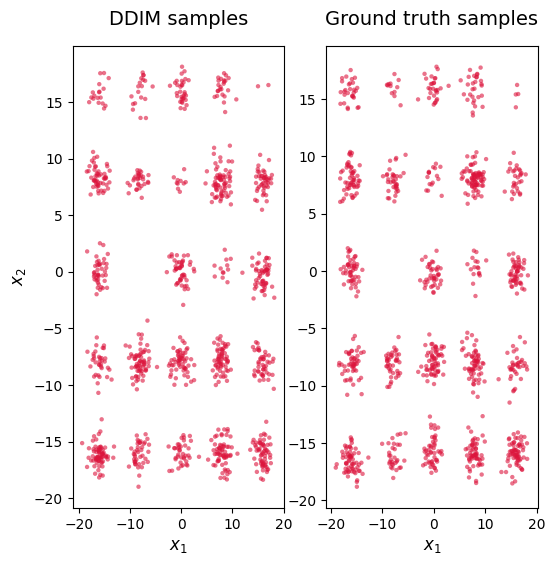

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
axes[0].scatter(
    ddim_samples[:, 0].detach().cpu().numpy(),
    ddim_samples[:, 1].detach().cpu().numpy(),
    s=10,
    alpha=0.6,
    c="crimson",
    edgecolors="none",
)

axes[1].scatter(
    samples[:, 0],
    samples[:, 1],
    s=10,
    alpha=0.6,
    c="crimson",
    edgecolors="none",
)
axes[0].set_title("DDIM samples", fontsize=14, pad=15)
axes[1].set_title("Ground truth samples", fontsize=14, pad=15)
for ax in axes:
    ax.set_xlabel("$x_1$", fontsize=12)

axes[0].set_ylabel("$x_2$", fontsize=12)
plt.show()

Tasks: 
- Compare the two distributions using your favorite distance (Wasserstein, sliced-Wasserstein...)
- Plot the distance as a function of DDIM steps (```n_steps```) and eta.

In [14]:
# Compute distance 

def distance(samples_target, samples_ddim):
    n_projections = 100
    dim = samples_target.shape[1]
    device = samples_target.device
    dtype = samples_target.dtype

    projections = torch.randn((n_projections, dim), device=device, dtype=dtype)
    projections = projections / torch.norm(projections, dim=1, keepdim=True)

    sw_distances = []
    for proj in projections:
        proj = proj.unsqueeze(1)
        target_proj = samples_target @ proj
        ddim_proj = samples_ddim @ proj

        target_proj_sorted, _ = torch.sort(target_proj, dim=0)
        ddim_proj_sorted, _ = torch.sort(ddim_proj, dim=0)

        sw_distance = torch.mean((target_proj_sorted - ddim_proj_sorted) ** 2)
        sw_distances.append(sw_distance.item())

    return np.mean(sw_distances)

sw_distance = distance(samples.detach().cpu(), ddim_samples.detach().cpu())
print(f"Sliced-Wassertein distance between DDIM samples and ground truth: {sw_distance:.4f}")


Sliced-Wassertein distance between DDIM samples and ground truth: 0.5605


## Diffusion model training

In this example, we work with simple 2D datasets (either a *swiss roll* or *two moons*) and embed them into a higher-dimensional ambient space. The goal is to illustrate how diffusion models can learn data whose **intrinsic dimension** is much smaller than the **ambient dimension** in which we represent it. This mimics realistic settings such as images or audio, where the high-dimensional representation contains strong low-dimensional structure.

---

## 1. Sampling the Base 2D Dataset

We begin by generating a toy dataset in two dimensions:

- **Swiss roll:** a nonlinear 2D manifold embedded in 3D, projected down to 2D using coordinates $(x_1, x_3)$ and rescaled.
- **Two moons:** a standard 2D synthetic dataset.

## 2. Embedding the Data into a 32-Dimensional Ambient Space

To study diffusion in a realistic high-dimensional setting, we embed the 2D data into $\mathbb{R}^{32}$.

We construct a random matrix $$Q \in \mathbb{R}^{32 \times 2}$$ and orthonormalize its columns via QR decomposition.

The embedding and projection operators are $Q$ and $Q^\top$. Thus the representation lives in 32 dimensions, but the underlying structure is still 2D.

⸻

## 3. Forward Diffusion in the Ambient Space

Once embedded, data points undergo the usual forward diffusion dynamics:

$$
x_t = \alpha_t x_0 + \sigma_t \varepsilon, \qquad
\varepsilon \sim \mathcal{N}(0, I_{32}).
$$

The noise is added in the 32D ambient space, even though the clean data lie on a 2D manifold.
This allows us to observe how diffusion models slowly destroy the underlying structure—and later how the denoiser attempts to reconstruct it.


This MLP is a simplified analogue of the denoisers used in modern diffusion models, but without convolutional structure. It is meant to provide a clear pedagogical example of how the denoising objective works, especially when the data lie in a low-dimensional manifold inside a higher-dimensional representation.

In [15]:
import numpy as np
from sklearn.datasets import make_swiss_roll, make_moons
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch import nn
import math

In [16]:
def get_data(n_samples, data_type):
    """
    Sample a toy 2D dataset for downstream diffusion experiments.
    Args:
        n_samples: Number of points to draw.
        data_type: Dataset name ('swiss_roll' or 'moons').
    Returns:
        Array of shape (n_samples, 2) containing the requested toy data.
    """
    if data_type == "swiss_roll":
        data, _ = make_swiss_roll(n_samples)
        data = data[:, [0, 2]] / 10.0
    elif data_type == "moons":
        data, _ = make_moons(n_samples)
    return data


ambient_dim = 32

Q = torch.randn(ambient_dim, 2)
Q, _ = torch.linalg.qr(Q)

embed = lambda x: x @ Q.T
project_back = lambda x: x @ Q

data = get_data(n_samples=8000, data_type="swiss_roll")

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], s=5, c="black", alpha=0.5)
plt.show()

NotImplementedError: The operator 'aten::linalg_qr.out' is not currently implemented for the MPS device. If you want this op to be considered for addition please comment on https://github.com/pytorch/pytorch/issues/141287 and mention use-case, that resulted in missing op as well as commit hash 5811a8d7da873dd699ff6687092c225caffcf1bb. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [ ]:
# prepare dataloader

batch_size = 1024
dataset = torch.tensor(data, dtype=torch.float32)
dataset = TensorDataset(dataset)
dataloader = DataLoader(dataset, batch_size=batch_size)

## Timestep Embeddings

We use a very small MLP for the sake of illustration. To condition the network on the timestep $t$, we use positional embeddings. We fix an embedding dimension $d \in \mathbb{N}$ and a maximum period $M > 0$. We define a sequence of frequencies
$$
\omega_k = \frac{1}{M^{\lfloor d / 2 \rfloor k}}
\qquad k = 0,1,\dots,m-1.
$$

For a scalar timestep $t \in \mathbb{R}$, the embedding is the vector
$$
e(t)
=
\big(
\cos(t \omega_0), \dots, \cos(t \omega_{m-1}),
\sin(t \omega_0), \dots, \sin(t \omega_{m-1})
\big)
\in \mathbb{R}^{2m}.
$$

If $d$ is odd, one additional zero coordinate is appended so that $e(t) \in \mathbb{R}^d$.

In [ ]:
## MLP denoiser definition 

def timestep_embedding(t, dim, max_period=10000.0):
    """
    Create sinusoidal timestep embeddings as in DDPM/Transformers.
    Args:
        t: Tensor of timesteps (B,).
        dim: Dimension of the embedding vector.
        max_period: Maximum period for the sine/cosine frequencies.
    Returns:
        Tensor of shape (B, dim) containing positional encodings of t.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period)
        * torch.arange(0, half, dtype=torch.float32, device=t.device)
        / half
    )
    args = t[:, None] * freqs[None, :]
    emb = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0, 1)) 
    return emb


class DenoisingMLP(nn.Module):
    """
    Timestep-conditioned MLP that predicts the clean sample x0.
    Args:
        dim: Dimensionality of the input data.
        tdim: Size of the timestep embedding.
        hidden: Width of the hidden layers.
    """
    def __init__(self, dim: int, tdim: int = 256, hidden: int = 256):
        super().__init__()
        self.tdim = tdim
        # self.time_encoder = nn.Embedding(1000, tdim)

        self.time_mlp = nn.Sequential(
            nn.Linear(tdim, tdim),
            nn.ReLU(),
            nn.Linear(tdim, tdim),
        )

        # self.time_encoder = nn.Sequential(
        #     nn.Linear(1, tdim), nn.ReLU(),
        # )
        self.net = nn.Sequential(
            nn.Linear(dim + tdim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim),
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Predict the clean sample x0 from a noised input and timestep.
        Args:
            x: Batch of noised samples.
            t: Timesteps corresponding to each sample.
        Returns:
            Network prediction of the underlying clean sample.
        """
        t = t / 1000
        if t.ndim == 0:
            t = t.unsqueeze(0)
        if t.shape[0] == 1:
            t = t.repeat(x.shape[0])
        t_emb = timestep_embedding(t, self.tdim).squeeze(0)
        t_feat = self.time_mlp(t_emb)  # (B, hidden)
        out = self.net(torch.cat([x, t_feat], dim=-1))  # (B, dim)
        return out

## Diffusion Training Objective

The denoising network receives $(X_t, t)$ and is trained to predict the clean sample $X_0$.  The loss is the mean-squared error

$$
\mathcal{L}
= \mathbb{E}\big[ \| \hat{x}^\theta _0(\alpha_t X_0 + \sigma_t X_1, t) - x_0 \|^2 \big],
$$
where $t$ is sampled uniformly and $X_0 \sim p_{\mathrm{data}}$ and $X_1 \sim \mathcal{N}(0, I)$. This is the standard DDPM objective for direct $x_0$-prediction.

In [ ]:
## Implement the training loss


def train_model(model, dataloader, alphas, sigmas, epochs=1000, lr=1e-3):
    """
    Train the denoising MLP with the DDPM mean-squared error objective.
    Args:
        model: Denoiser mapping (x_t, t) to x0.
        dataloader: Iterator over the clean dataset.
        alphas: Alpha schedule used to generate noisy training pairs.
        sigmas: Sigma schedule matched to alphas.
        epochs: Number of training epochs.
        lr: Learning rate for Adam.
    Returns:
        List of losses recorded over training.
    """
    pass 

ValueError: x, y, and format string must not be None

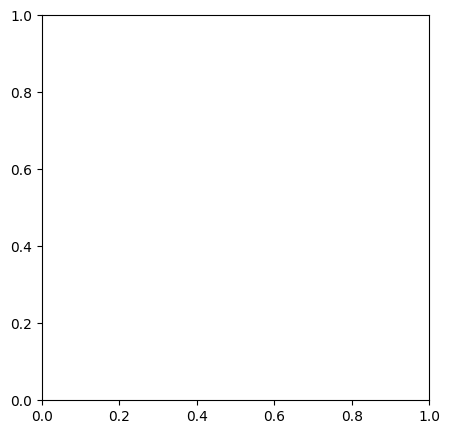

In [ ]:
alphas, sigmas = mk_schedule(schedule_type="linear")
denoising_net = DenoisingMLP(dim=ambient_dim, tdim=20)

losses = train_model(
    model=denoising_net,
    dataloader=dataloader,
    alphas=alphas,
    sigmas=sigmas,
    epochs=3000,
    lr=1e-3,
)

plt.figure(figsize=(5, 5))
plt.plot(losses)
plt.show()

In [ ]:
alphas, sigmas = mk_schedule(schedule_type="linear")

initial_noise = torch.randn((1000, ambient_dim))

with torch.no_grad():
    ddim_samples = ddim(
        initial_noise=initial_noise,
        denoiser_fn=denoising_net,
        alphas=alphas,
        sigmas=sigmas,
        n_steps=500,
        eta=0.0,
    )

ddim_samples = project_back(ddim_samples)
ddim_samples = ddim_samples.cpu()
plt.figure(figsize=(5, 5))
plt.scatter(ddim_samples[:, 0], ddim_samples[:, 1])
plt.show()

## Image generation with Diffusion models (CelebA-HQ 256×256)

In this part, we move from toy low-dimensional examples to a **real image diffusion model** trained on the CelebA-HQ dataset at resolution $256 \times 256$.

We load a pretrained DDPM from the Hugging Face `diffusers` library:

- `DDPMPipeline` bundles together:
  - a **UNet denoiser** (the neural network that predicts noise or $x_0$ from a noised image and a timestep),
  - a **scheduler** that implements the reverse diffusion steps,
  - some convenience logic for sampling images from pure Gaussian noise.

In [17]:
import torch
from diffusers import DDPMPipeline

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(torch.backends.mps.is_available())

hf_id = "google/ddpm-celebahq-256"
pipeline = DDPMPipeline.from_pretrained(hf_id).to(device)
model = pipeline.unet
model = model.requires_grad_(False)
model = model.eval()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


True


Loading pipeline components...:  50%|█████     | 1/2 [00:01<00:01,  1.06s/it]An error occurred while trying to fetch /Users/adamelbernoussi/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/adamelbernoussi/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


## Custom variance-preserving schedule and DDIM-compatible denoiser

The pretrained CelebA-HQ model from `diffusers` uses a **variance-preserving (VP)** diffusion process.  
In this parameterization, the forward noising process is

$$
X_t = \sqrt{\bar{\alpha}_t}\, X_0 + \sqrt{1 - \bar{\alpha}_t}\, X_1,
\qquad X_1 \sim \mathcal{N}(0, I),
$$

where $\bar{\alpha}_t$ is the cumulative product of per-step factors $1 - \beta_s$.

The scheduler in the pipeline already provides these cumulative products as `pipeline.scheduler.alphas_cumprod`.  
We turn them into the $(\alpha_t, \sigma_t)$ pair used in our DDIM-style sampler by setting
$$
\alpha_t = \sqrt{\bar{\alpha}_t}, 
\qquad 
\sigma_t = \sqrt{1 - \bar{\alpha}_t}.
$$

The UNet contained in the pipeline is trained to predict the **noise** $X_1$ given $(X_t, t)$; i.e. $\mathbb{E}[X_1 | X_t]$. this is often called an *noise prediction* or *epsilon prediction*. If we denote this prediction by $\hat{X}_1(X_t, t)$, then from
$$
X_t = \alpha_t X_0 + \sigma_t X_1,
$$
we obtain the corresponding estimate of the clean latent
$$
\hat{X}_0(X_t, t)
= \frac{X_t - \sigma_t \, \hat{X}_1(X_t, t)}{\alpha_t}.
$$

Thus, to use a generic DDIM sampler that expects an $X_0$-predicting denoiser, we first wrap the UNet’s noise prediction into this formula to convert it into an $X_0$-prediction.

In [18]:


alphas_cumprod = pipeline.scheduler.alphas_cumprod.clip(1e-6, 1)
alphas = alphas_cumprod.sqrt()
sigmas = (-torch.expm1(alphas_cumprod.log())).sqrt()


def celeba_denoiser(x, t):
    """
    Wrap the diffusion pipeline model to conform to the DDIM denoiser API.
    Args:
        x: Latent at timestep t.
        t: Integer timestep index (or tensor of indices).
    Returns:
        Prediction of the clean latent x0 at timestep t.
    """
    if t.ndim == 0:
        t = t.unsqueeze(0)
    if t.shape[0] == 1:
        t = t.repeat(x.shape[0])
    t = (t / (len(alphas) - 1) * (pipeline.scheduler.num_train_timesteps - 1)).long()
    model_output = model(x, t).sample
    alpha_t = alphas[t][:, None, None, None]
    sigma_t = sigmas[t][:, None, None, None]
    pred_x0 = (x - sigma_t * model_output) / alpha_t
    return pred_x0


initial_noise = torch.randn(2, 3, 256, 256, device=device)

samples = ddim(
    initial_noise=initial_noise,
    denoiser_fn=celeba_denoiser,
    alphas=alphas,
    sigmas=sigmas,
    n_steps=100,
    eta=0.0,
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


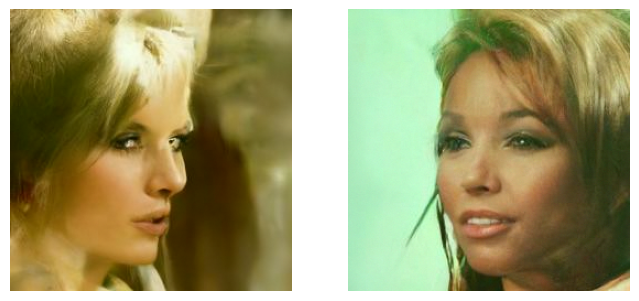

In [19]:
fig, axes = plt.subplots(1, samples.shape[0], figsize=(4 * samples.shape[0], 4))
for ax, img in zip(axes, samples):
    ax.imshow(((img + 1) / 2).permute(1, 2, 0).cpu())
    ax.axis("off")
plt.show()